# Shapley value demo

Shapley values are a measure the influence of a given feature on a machine learning model's output. While open source libraries that are well-optimized exist, this notebook is meant to demonstrate the underlying principles behind Shapley values.

Note: if you just want a library to calculate Shapley values, then you are better served checking out the open source [SHAP library](https://shap.readthedocs.io/en/latest/). The point of this notebook is to help the reader understand how we calculate Shapley values from scratch.

First, let's train a linear regression model on the  `diabetes` dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
rmse_train = np.sqrt(np.mean(np.power(y_train - model.predict(X_train), 2)))
rmse_test = np.sqrt(np.mean(np.power(y_test - model.predict(X_test), 2)))
print(f"train RMSE: {rmse_train:4.3f}, test RMSE: {rmse_test:4.3f}")

train RMSE: 53.919, test RMSE: 53.370


With a trained model, we are ready to calculate some Shapley values!

First, we will need to select a *background split* of data. Let's just pick a subset of the training set.

In [ ]:
X_bg, _, y_bg, _ = train_test_split(X_train, y_train, train_size=100)

Suppose we want to calculate the Shapley values for a given record. This means we are calculating a value for each feature in the record. For the diabetes data, the features are the following:

In [ ]:
X_train.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')


For each feature, we will be using data to "fill in" the other feature values in order to "perturb" the model around the given feature value of interest. This will alter the model's output, and the Shapley value will be the average difference between the perturbed model outputs and the original model output on the record (i.e., `y_bg`). 

In [ ]:
X_shap = X_bg.copy()
X_shap.iloc[:,0] = 0.0
X_shap.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
162,0.0,-0.044642,0.030440,-0.074527,-0.023584,-0.011335,-0.002903,-0.002592,-0.030748,-0.001078
345,0.0,0.050680,-0.002973,-0.033213,0.042462,0.057871,-0.010266,0.034309,-0.000612,-0.001078
381,0.0,0.050680,-0.089197,-0.074527,-0.042848,-0.025739,-0.032356,-0.002592,-0.012909,-0.054925
306,0.0,0.050680,-0.001895,0.021872,-0.038720,-0.024800,-0.006584,-0.039493,-0.039809,-0.013504
294,0.0,0.050680,-0.030996,-0.005670,-0.016704,0.017788,-0.032356,-0.002592,-0.074093,-0.034215


In [ ]:
def shapley_val(model, x, X_bg, y_bg):
    """calculate the Shapley value for a given record using the background data
        model (sklearn.estimator): model to calculate Shapley values for
        x (Sequence[float]): record of interest
        X_bg (pd.DataFrame): X for background data split
        y_bg (pd.DataFrame): y for background data split
    """
    shap_vals = np.zeros_like(x)
    for i in range(X_bg.shape[1]):
        X_shap = X_bg.copy()
        X_shap.iloc[:,i] = x.iloc[i]
        y_shap = model.predict(X_shap)
        shap_vals[i] = np.mean(y_shap - y_bg)
    return shap_vals
        

In [ ]:
X_train.iloc[0,:].shape

(10,)

In [ ]:
infl = shapley_val(model, X_train.iloc[0,:], X_bg, y_bg)

Let's take a look at the Shapley values for this record.

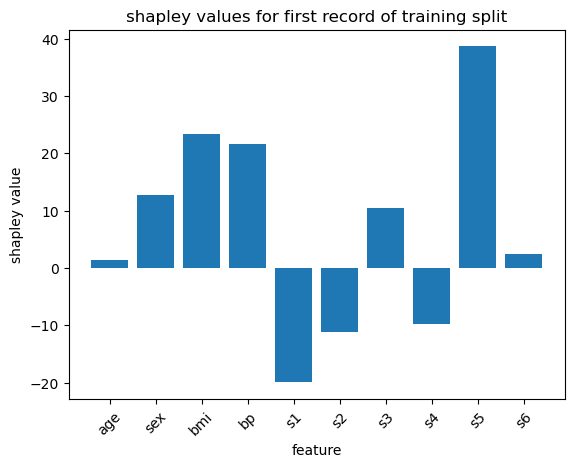

In [ ]:
import matplotlib.pyplot as plt

x_axis_vals = np.arange(infl.shape[0])
feature_names = X_bg.columns.to_numpy()
plt.bar(x=x_axis_vals, height=infl)#, bottom=y.iloc[0])
plt.xticks(x_axis_vals, feature_names, rotation=45)
plt.xlabel("feature")
plt.ylabel("shapley value")
plt.title("shapley values for first record of training split")
plt.show()

Now, lets calculate the shapley values for all the records in the training split.

In [ ]:
def get_shapley_values(model, X, X_bg, y_bg):
    infl = np.zeros_like(X)
    for i in range(X.shape[0]):
        infl[i,:] = shapley_val(model, X.iloc[i,:], X_bg, y_bg)

    return pd.DataFrame(infl, columns=X_bg.columns)

In [ ]:
df_infl = get_shapley_values(model, X_train, X_bg, y_bg)

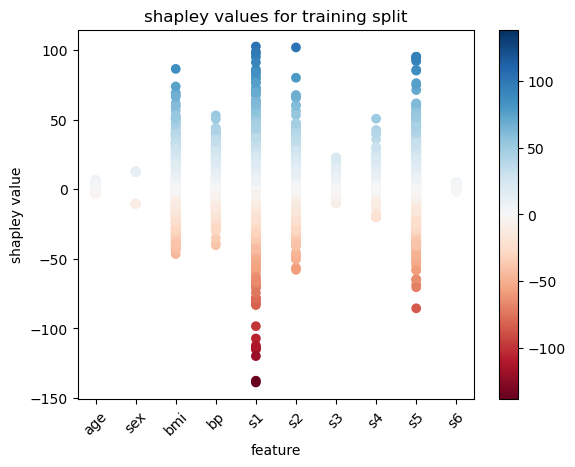

In [ ]:
from matplotlib.colors import Normalize

def plot_shapley_values(df_infl):
    abs_max = np.max(np.abs([df_infl.min().min(), df_infl.max().max()]))
    norm = Normalize(vmin=-abs_max, vmax=abs_max)
    features_names = df_infl.columns.to_numpy()
    x_axis_vals = np.arange(len(feature_names))
    for i in range(df_infl.shape[0]):
        plt.scatter(x=x_axis_vals, y=df_infl.iloc[i,:], c=df_infl.iloc[i,:], norm=norm, cmap="RdBu")
    plt.xticks(x_axis_vals, feature_names, rotation=45)
    plt.xlabel("feature")
    plt.ylabel("shapley value")
    plt.title("shapley values for training split")
    plt.colorbar()
    plt.show()

plot_shapley_values(df_infl)

From the plot above, we can draw a few conclusions:
- The `bmi`, `bp`, `s1`, `s2`, and `s5` features are relatively influential. The `s1` biomarker in particular has some particularly influential points!
- The `age`, `sex`, and `s6` features are relatively not influential.
- The influence of `sex` seems to be positively influential in one direction and negatively influential in the other.

A useful view of Shapley values is the influence-sensitivity plot (ISP), which plots Shapley values vs. their corresponding feature values.

In [ ]:
def plot_isp(X, infl, feat_name):
    plt.scatter(X[feat_name], infl[feat_name], alpha=0.25)
    plt.xlabel(feat_name)
    plt.ylabel("shapley value")
    plt.title(f"ISP for '{feat_name}'")
    plt.show()

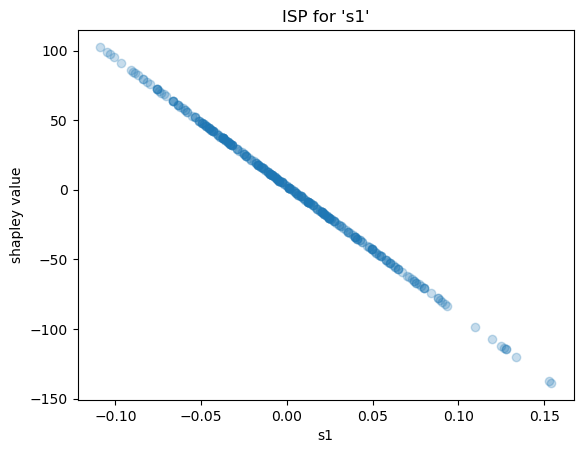

In [ ]:
plot_isp(X_train, df_infl, 's1')

Considering that we used a `LinearRegression` model, it makes sense that the ISP is also linear. Let's try a different model and see what the corresponding ISP looks like.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

rmse_train = np.sqrt(np.mean(np.power(y_train - gb_model.predict(X_train), 2)))
rmse_test = np.sqrt(np.mean(np.power(y_test - gb_model.predict(X_test), 2)))
print(f"train RMSE: {rmse_train:4.3f}, test RMSE: {rmse_test:4.3f}")

train RMSE: 30.091, test RMSE: 56.362


In [ ]:
df_infl_gb = get_shapley_values(gb_model, X_train, X_bg, y_bg)

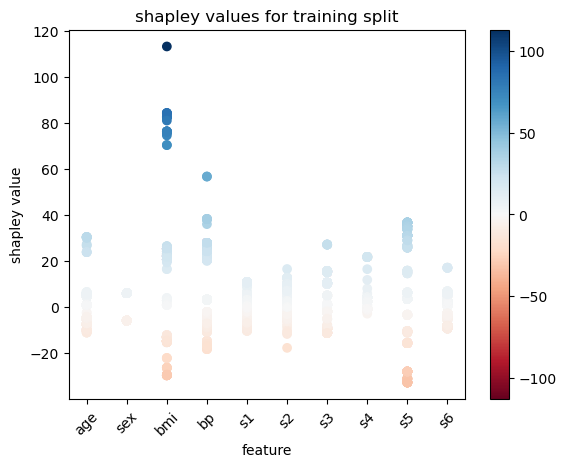

In [ ]:
plot_shapley_values(df_infl_gb)

For the gradient boosted regressor, the influential features have changed.

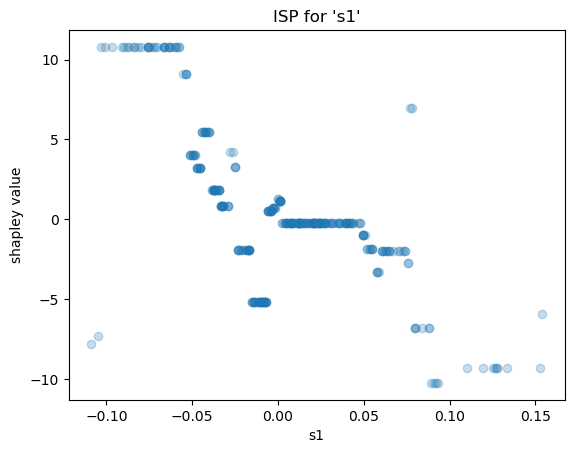

In [ ]:
plot_isp(X_train, df_infl_gb, 's1')

As a tree-based model, the ISP is no longer linear.